In [12]:
import numpy as np
import pickle
import netCDF4 as nc
import matplotlib.pyplot as plt
import matplotlib
import datetime
from matplotlib.colors import ListedColormap
import cmocean
import sys
sys.path.insert(1, '/ocean/brogalla/GEOTRACES/analysis-brogalla/paper1/figures/')
import modules.mapping_functions as mf
import pandas as pd
from mpl_toolkits.basemap import Basemap, cm
import xarray as xr
import gsw

%matplotlib inline

In [13]:
imin, imax = 1479, 2179
jmin, jmax = 159, 799
isize = imax - imin
jsize = jmax - jmin

# colormap:
N = 256
vals_cont = np.ones((N, 4))
vals_cont[:, 0] = np.linspace(101/N, 1, N)
vals_cont[:, 1] = np.linspace(100/N, 1, N)
vals_cont[:, 2] = np.linspace(97/N, 1, N)
sed_cmap = ListedColormap(vals_cont).reversed()

light_color = '#d0d0cf'
land_edge = '#929291'

In [5]:
# Define boundary latitudes and longitudes for the Laptev Sea region
trajS_bdy1 = 68; trajN_bdy1 = 74; trajE_bdy1 = -170; trajW_bdy1 = -210;
trajS_bdy2 = 70; trajN_bdy2 = 75; trajE_bdy2 = -185; trajW_bdy2 = -230;

WE_bdy1A = np.linspace(trajW_bdy1, trajE_bdy1, 30)
WE_bdy1B = np.linspace(trajE_bdy2, trajE_bdy1, 30)
WES_bdy1 = np.ones(WE_bdy1A.shape)*trajS_bdy1
WEN_bdy1 = np.ones(WE_bdy1A.shape)*trajN_bdy1

SN_bdy1A = np.linspace(trajS_bdy1, trajS_bdy2, 30)
SN_bdy1B = np.linspace(trajS_bdy1, trajN_bdy1, 30)
SNW_bdy1 = np.ones(SN_bdy1A.shape)*trajW_bdy1
SNE_bdy1 = np.ones(SN_bdy1A.shape)*trajE_bdy1

WE_bdy2A = np.linspace(trajW_bdy2, trajW_bdy1, 30)
WE_bdy2B = np.linspace(trajW_bdy2, trajE_bdy2, 30)
WES_bdy2 = np.ones(WE_bdy2A.shape)*trajS_bdy2
WEN_bdy2 = np.ones(WE_bdy2A.shape)*trajN_bdy2

SN_bdy2A = np.linspace(trajS_bdy2, trajN_bdy2, 30)
SN_bdy2B = np.linspace(trajN_bdy1, trajN_bdy2, 30)
SNW_bdy2 = np.ones(SN_bdy2A.shape)*trajW_bdy2
SNE_bdy2 = np.ones(SN_bdy2A.shape)*trajE_bdy2

In [6]:
# model results:
year = 2015
results_folder1 = f'/data/brogalla/run_storage/Mn-reference-202204/ANHA12_ref-{year}_20220422/'

results  = nc.Dataset(f'{results_folder1}ANHA12_EXH006_{year}_monthly.nc')
dissolmn = np.array(results.variables['dissolmn'][:,0,:,:,:])*1e9 # nM units
oxidismn = np.array(results.variables['oxidismn'][:,0,:,:,:])*1e9 # nM units

In [7]:
mesh       = nc.Dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mesh1.nc')
ANHA12_lon = np.array(mesh.variables['nav_lon'])
ANHA12_lat = np.array(mesh.variables['nav_lat'])
mesh_bathy = np.array(mesh.variables['hdept'][0])
tmask      = np.array(mesh.variables['tmask'])
land_mask  = np.ma.masked_where((tmask[0,:,:,:] > 0.1) , tmask[0,:,:,:]) 

tmask_sub  = np.array(mesh.variables['tmask'])[0,:,imin:imax,jmin:jmax]
e3t        = np.array(mesh.variables['e3t_0'])[0,:,imin:imax,jmin:jmax]
e3t_masked = np.ma.masked_where((tmask_sub[:,:,:] < 0.1), e3t)

ref   = nc.Dataset(f'{results_folder1}ANHA12_EXH006_{year}_monthly.nc',  'r')
lons_model  = np.array(ref.variables['nav_lon'])
lats_model  = np.array(ref.variables['nav_lat'])
depth_model = np.array(ref.variables['deptht'])

In [8]:
def drawCirc1(ax,radius,centX,centY,angle_,theta2_,color_='black'):
    #========Create the arrow head
    endX=centX-(radius/2)*np.cos(np.radians(theta2_+angle_)) #Do trig to determine end position
    endY=centY+(radius/2)*np.sin(np.radians(theta2_+angle_))

    #Create triangle as arrow head
    ax.add_patch(matplotlib.patches.RegularPolygon((endX, endY), # (x,y)
            3,                       # number of vertices
            radius/6,                # radius
            np.radians(angle_+theta2_),     # orientation
            color='k', zorder=3))
    ax.add_patch(matplotlib.patches.RegularPolygon((endX, endY), # (x,y)
            3,                       # number of vertices
            radius/9,                # radius
            np.radians(angle_+theta2_),     # orientation
            color=color_, zorder=3))
    
    #========Line
    arc = matplotlib.patches.Arc([centX,centY],radius,radius,angle=angle_,
          theta1=25,theta2=theta2_,linestyle='-',lw=2,color=color_, zorder=3)
    arc2 = matplotlib.patches.Arc([centX,centY],radius,radius,angle=angle_,
          theta1=40,theta2=theta2_+4,linestyle='-',lw=3,color='k', zorder=3)
    ax.add_patch(arc2)
    ax.add_patch(arc)
    
#     ax.set_xlim([centX-radius,centY+radius]) and ax.set_ylim([centY-radius,centY+radius]) 

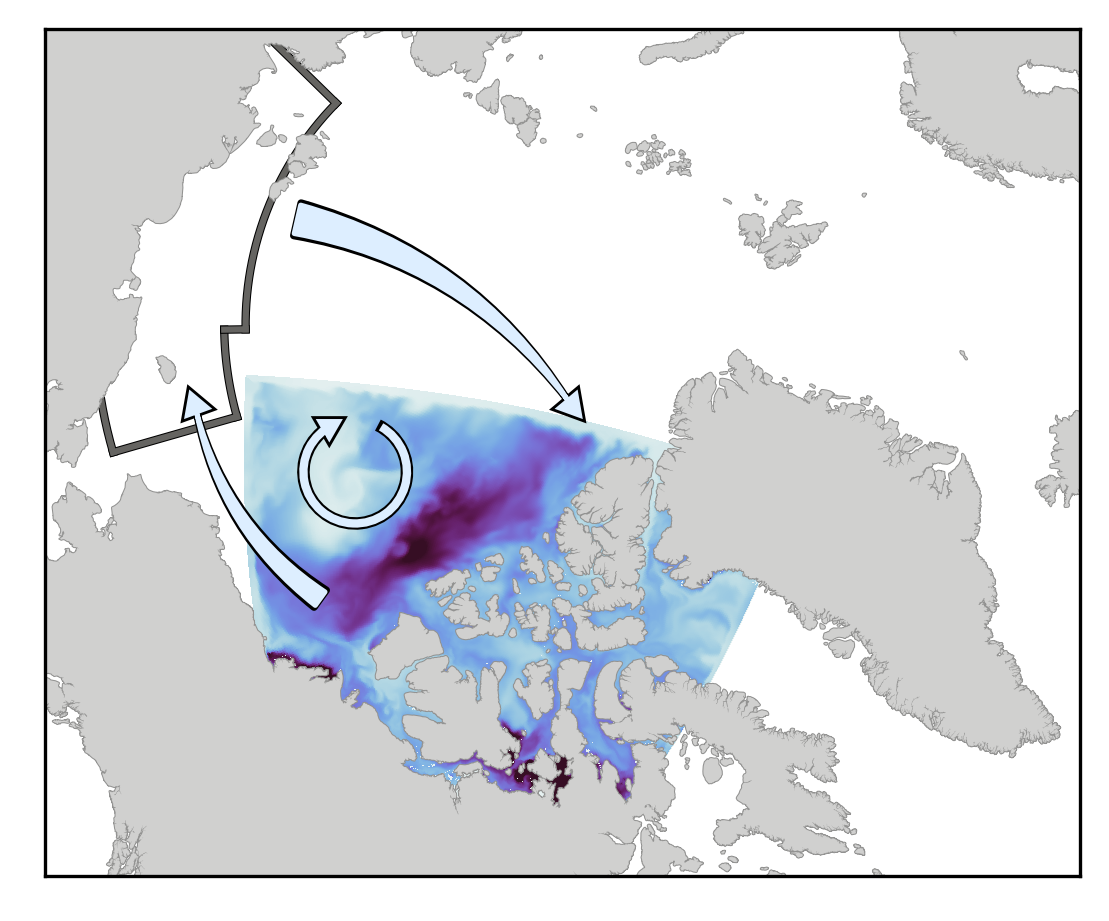

In [33]:
fig, ax1 = plt.subplots(figsize=(4.5, 3.74), dpi=300)

proj1 = Basemap(projection='stere',lat_0 = 84, lon_0 = -95, resolution='i', width=5.5e6, height=4.5e6, ax=ax1)
proj1.drawcoastlines(color=land_edge, linewidth=0.5)
proj1.fillcontinents(color=light_color, lake_color=light_color, zorder=2);

x_model, y_model = proj1(ANHA12_lon, ANHA12_lat)
# bath   = proj1.contourf(x_model, y_model, mesh_bathy, 20, cmap=matplotlib.cm.get_cmap('Blues'), vmin=0, vmax=4000, zorder=1)

# Siberian shelf boundaries: --------------------------------------------------------
xS1, yS1 = proj1(WE_bdy1A, WES_bdy1); xN1, yN1 = proj1(WE_bdy1B, WEN_bdy1);
xW1, yW1 = proj1(SNW_bdy1, SN_bdy1A); xE1, yE1 = proj1(SNE_bdy1, SN_bdy1B);

xS2, yS2 = proj1(WE_bdy2A, WES_bdy2); xN2, yN2 = proj1(WE_bdy2B, WEN_bdy2); 
xW2, yW2 = proj1(SNW_bdy2, SN_bdy2A); xE2, yE2 = proj1(SNE_bdy2, SN_bdy2B);

color_line1 = '-k'; color_line2 = '-';
linewidth1  = 2.0; linewidth2  = 1.5;

proj1.plot(xS1, yS1, color_line1, linewidth=linewidth1, zorder=1); proj1.plot(xN1, yN1, color_line1, linewidth=linewidth1, zorder=1);
proj1.plot(xW1, yW1, color_line1, linewidth=linewidth1, zorder=1); proj1.plot(xE1, yE1, color_line1, linewidth=linewidth1, zorder=1);
proj1.plot(xS1, yS1, color_line2, linewidth=linewidth2, c='#656461', zorder=1)
proj1.plot(xN1, yN1, color_line2, linewidth=linewidth2, c='#656461', zorder=1)
proj1.plot(xW1, yW1, color_line2, linewidth=linewidth2, c='#656461', zorder=1)
proj1.plot(xE1, yE1, color_line2, linewidth=linewidth2, c='#656461', zorder=1)

proj1.plot(xS2, yS2, color_line1, linewidth=linewidth1, zorder=1); proj1.plot(xN2, yN2, color_line1, linewidth=linewidth1, zorder=1);
proj1.plot(xW2, yW2, color_line1, linewidth=linewidth1, zorder=1); proj1.plot(xE2, yE2, color_line1, linewidth=linewidth1, zorder=1);
proj1.plot(xS2, yS2, color_line2, linewidth=linewidth2, c='#656461', zorder=1)
proj1.plot(xN2, yN2, color_line2, linewidth=linewidth2, c='#656461', zorder=1)
proj1.plot(xW2, yW2, color_line2, linewidth=linewidth2, c='#656461', zorder=1)
proj1.plot(xE2, yE2, color_line2, linewidth=linewidth2, c='#656461', zorder=1)

# Surface field ---------------------------------------------------------------------
x, y    = proj1(lons_model, lats_model)
pcolor  = proj1.pcolormesh(x, y, dissolmn[8,0,:,:], cmap=cmocean.cm.dense, vmin=0, vmax=20)
proj1.line()

# Arrows ----------------------------------------------------------------------------
drawCirc1(ax1,0.55e6,1.65e6,2.15e6,90,330, color_='#ddeeff')
TPD2 = matplotlib.patches.FancyArrowPatch((1.3e6, 3.5e6), (2.8e6,2.5e6),\
                                        connectionstyle="arc3,rad=-.2", \
                                        color='k', linewidth=1.8, \
                                        arrowstyle='wedge, tail_width=8', zorder=3)
TPD = matplotlib.patches.FancyArrowPatch((1.3e6, 3.5e6), (2.8e6,2.5e6),\
                                        connectionstyle="arc3,rad=-.2", \
                                        color='#ddeeff', linewidth=1.2, \
                                        arrowstyle='wedge, tail_width=7', zorder=3)

ax1.add_patch(matplotlib.patches.RegularPolygon((2.8e6,2.5e6), 3, 1e5, np.radians(-20), color='k', zorder=3))
ax1.add_patch(TPD2); ax1.add_patch(TPD);
ax1.add_patch(matplotlib.patches.RegularPolygon((2.8e6,2.5e6), 3, 0.7e5, np.radians(-20), color='#ddeeff', zorder=3))


BS2 = matplotlib.patches.FancyArrowPatch((1.5e6, 1.45e6), (8e5,2.5e6),\
                                        connectionstyle="arc3,rad=-.2", \
                                        color='k', linewidth=1.8, \
                                        arrowstyle='wedge, tail_width=5', zorder=3)
BS = matplotlib.patches.FancyArrowPatch((1.5e6, 1.45e6), (8e5,2.5e6),\
                                        connectionstyle="arc3,rad=-.2", \
                                        color='#ddeeff', linewidth=1.2, \
                                        arrowstyle='wedge, tail_width=4', zorder=3)
ax1.add_patch(matplotlib.patches.RegularPolygon((8e5,2.5e6), 3, 1e5, np.radians(20), color='k', zorder=3))
ax1.add_patch(BS2); ax1.add_patch(BS);
ax1.add_patch(matplotlib.patches.RegularPolygon((8e5,2.5e6), 3, 0.7e5, np.radians(20), color='#ddeeff', zorder=3))

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/summary.jpg', \
#                bbox_inches='tight', dpi=300)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/summary.svg', \
#                format='svg', bbox_inches='tight', dpi=300)